# 계산 노예

In [1]:
import sys

print(sys.executable)

/usr/bin/python3


In [2]:
import sympy as sp
import custom_sympy as csp

In [3]:
# 시간 정의
t = sp.symbols("t", real=True)

# 상수 정의
m, M, l, g = sp.symbols("m M l g", real=True)
fric_x, fric_theta = sp.symbols("fric_x fric_theta", real=True)


# 차량에 대한 외력 정의
f = sp.symbols("f", real=True)

# state 변수 정의
x = sp.Function("x")(t)
theta = sp.Function("theta")(t)
x_dot = x.diff(t)
theta_dot = theta.diff(t)
x_ddot = x_dot.diff(t)
theta_ddot = theta_dot.diff(t)

state = csp.make_state_vector([(x, 1), (theta, 1)], t)


# 각 질량체의 x,y 좌표 정의
cart_pos_x = x
cart_pos_y = 0
pendulum_pos_x = x + l * sp.sin(theta)
pendulum_pos_y = l * sp.cos(theta)

# 각 질량체의 속도의 제곱
cart_vel_sqare = cart_pos_x.diff(t) ** 2
pendulum_vel_sqare = pendulum_pos_x.diff(t) ** 2 + pendulum_pos_y.diff(t) ** 2

# 시스템의 총 위치에너지와 운동에너지
V = m * g * pendulum_pos_y  # 위치에너지
T = 1 / 2 * M * cart_vel_sqare + 1 / 2 * m * pendulum_vel_sqare  # 운동에너지

# 라그랑지안
L = T - V
L.simplify()

# 각 좌표계에 대한 라그랑주 방정식. 마찰력과 외력을 포함한다.
x_eq = sp.Eq(L.diff(x_dot).diff(t) - L.diff(x), f).simplify()
theta_eq = sp.Eq(L.diff(theta_dot).diff(t) - L.diff(theta), 0).simplify()

solution = sp.solve([x_eq, theta_eq], [x_ddot, theta_ddot])

sol_x_ddot = solution[x_ddot].simplify()
sol_theta_ddot = solution[theta_ddot].simplify()

state_dot = state.diff(t).subs([(x_ddot, sol_x_ddot), (theta_ddot, sol_theta_ddot)])

csp.make_state_comfy_to_see(sp.Eq(state.diff(t), state_dot))

Eq(Matrix([
[     xdot],
[    xddot],
[ thetadot],
[thetaddot]]), Matrix([
[                                                                                                       xdot],
[                                (f - g*m*sin(2*theta)/2 + l*m*thetadot**2*sin(theta))/(M + m*sin(theta)**2)],
[                                                                                                   thetadot],
[(M*g*sin(theta) - f*cos(theta) + g*m*sin(theta) - l*m*thetadot**2*sin(2*theta)/2)/(l*(M + m*sin(theta)**2))]]))

f(x)를 찾아낸다.

In [4]:
# f(x)
f_x = state_dot.subs(f, 0)
f_x = sp.simplify(f_x)
csp.make_state_comfy_to_see(f_x)

Matrix([
[                                                                         xdot],
[           m*(-g*cos(theta) + l*thetadot**2)*sin(theta)/(M + m*sin(theta)**2)],
[                                                                     thetadot],
[(M*g + g*m - l*m*thetadot**2*cos(theta))*sin(theta)/(l*(M + m*sin(theta)**2))]])

g(x)를 찾아낸다.

In [5]:
g_x = (state_dot - f_x) / f
g_x = sp.simplify(g_x)
csp.make_state_comfy_to_see(g_x)

Matrix([
[                                    0],
[              1/(M + m*sin(theta)**2)],
[                                    0],
[-cos(theta)/(l*(M + m*sin(theta)**2))]])

## HO-CBF 만들기

2차 order CBF를 만들 것이다. 이것의 식은 다음과 같다.

$$\ddot{h}+\alpha(\dot{h}) \geq 0$$


응~ 틀렸어! 찬찬히 봐봐. 우선, $\alpha(x) = k x$라고 하자.
$$\begin{aligned}
\psi_0(\mathbf{x}) &:= h(\mathbf{x}) \\
\psi_1(\mathbf{x}) &:= \dot{\psi}_0(\mathbf{x}) + k_1 \psi_0(\mathbf{x}) \\
&= \dot{h}(\mathbf{x}) + k_1 h(\mathbf{x}) \\
\psi_2(\mathbf{x}) &:= \dot{\psi}_1(\mathbf{x}) + k_2 \psi_1(\mathbf{x}) \\
&= \ddot{h}(\mathbf{x}) + k_2 \dot{h}(\mathbf{x}) + k_2 k_1 h(\mathbf{x})
\end{aligned}$$

그러니까 부등식은 다음과 같아야해.
$$\ddot{h}(\mathbf{x}) + k_2 \dot{h}(\mathbf{x}) + k_2 k_1 h(\mathbf{x}) \geq 0 $$

우선 $h(x)$를 정의한다.

In [6]:
x_min = sp.symbols("x_min", real=True)
x_max = sp.symbols("x_max", real=True)

h_x = -(state[0] - x_min) * (state[0] - x_max)

h_x

(-x_max + x(t))*(x_min - x(t))

$\frac{dh}{d\mathbf{x}}$ 계산

In [7]:
dh_dstate = h_x.diff(state).T
dh_dstate

Matrix([[x_max + x_min - 2*x(t), 0, 0, 0]])

$\dot{h}$를 구한다.

In [8]:
h_dot_x = csp.make_11matrix_to_scalar(dh_dstate @ f_x + dh_dstate @ g_x)
csp.make_state_comfy_to_see(h_dot_x)

xdot*(-2*x + x_max + x_min)

그 다음 

$$\ddot{h}=\frac{d\dot{h}}{d\mathbf{x}}f(\mathbf{x}) + \frac{d\dot{h}}{d\mathbf{x}}g(\mathbf{x})$$

이므로 $\frac{d\dot{h}}{d\mathbf{x}}$를 구한다.

In [9]:
dh_dot_x_dstate = h_dot_x.diff(state).T
csp.make_state_comfy_to_see(dh_dot_x_dstate)

Matrix([[-2*xdot, -2*x + x_max + x_min, 0, 0]])

따라서 $\ddot{h}$는 다음과 같다.

In [10]:
h_ddot_x = dh_dot_x_dstate @ f_x + dh_dot_x_dstate @ g_x * f

h_ddot_x = csp.make_11matrix_to_scalar(h_ddot_x)

csp.make_state_comfy_to_see(h_ddot_x)

(f*(-2*x + x_max + x_min) - m*(g*cos(theta) - l*thetadot**2)*(-2*x + x_max + x_min)*sin(theta) - 2*xdot**2*(M + m*sin(theta)**2))/(M + m*sin(theta)**2)

$$\ddot{h}(\mathbf{x}) + k_2 \dot{h}(\mathbf{x}) + k_2 k_1 h(\mathbf{x}) \geq 0$$ 
이걸 구현하자.

In [11]:
k_1, k_2 = sp.symbols("k_1 k_2", real=True)
u = sp.symbols("u", real=True)
ineq = (h_ddot_x + k_2 * h_dot_x + k_2 * k_1 * h_x >= 0).simplify().subs(f, u)
csp.make_state_comfy_to_see(ineq)

(k_2*(M + m*sin(theta)**2)*(-k_1*(-x + x_max)*(-x + x_min) + xdot*(-2*x + x_max + x_min)) - m*(g*cos(theta) - l*thetadot**2)*(-2*x + x_max + x_min)*sin(theta) + u*(-2*x + x_max + x_min) - 2*xdot**2*(M + m*sin(theta)**2))/(M + m*sin(theta)**2) >= 0

분모가 항상 0보다 크다. 분모 제거

In [12]:
D = M + m * sp.sin(theta) ** 2
ineq1 = ineq.lhs * D >= 0
ineq1 = ineq1.simplify()
csp.make_state_comfy_to_see(ineq1)

k_2*(M + m*sin(theta)**2)*(k_1*(-x + x_max)*(-x + x_min) - xdot*(-2*x + x_max + x_min)) + m*(g*cos(theta) - l*thetadot**2)*(-2*x + x_max + x_min)*sin(theta) - u*(-2*x + x_max + x_min) + 2*xdot**2*(M + m*sin(theta)**2) <= 0

$a(\mathbf{x}) u \leq b(\mathbf{x})$꼴로 고친다.

In [13]:
ineq2 = sp.solve(ineq1, u).simplify()
csp.make_state_comfy_to_see(ineq2)

u*(2*x - x_max - x_min) <= -M*k_1*k_2*x**2 + M*k_1*k_2*x*x_max + M*k_1*k_2*x*x_min - M*k_1*k_2*x_max*x_min - 2*M*k_2*x*xdot + M*k_2*x_max*xdot + M*k_2*x_min*xdot - 2*M*xdot**2 + g*m*x*sin(2*theta) - g*m*x_max*sin(2*theta)/2 - g*m*x_min*sin(2*theta)/2 - k_1*k_2*m*x**2*sin(theta)**2 + k_1*k_2*m*x*x_max*sin(theta)**2 + k_1*k_2*m*x*x_min*sin(theta)**2 - k_1*k_2*m*x_max*x_min*sin(theta)**2 - 2*k_2*m*x*xdot*sin(theta)**2 + k_2*m*x_max*xdot*sin(theta)**2 + k_2*m*x_min*xdot*sin(theta)**2 - 2*l*m*thetadot**2*x*sin(theta) + l*m*thetadot**2*x_max*sin(theta) + l*m*thetadot**2*x_min*sin(theta) - 2*m*xdot**2*sin(theta)**2

In [14]:
u_side = ineq2.lhs.simplify()
other_side = ineq2.rhs.simplify()

In [15]:
csp.make_state_comfy_to_see(u_side)

u*(2*x - x_max - x_min)

In [16]:
csp.make_state_comfy_to_see(other_side)

-M*k_1*k_2*x**2 + M*k_1*k_2*x*x_max + M*k_1*k_2*x*x_min - M*k_1*k_2*x_max*x_min - 2*M*k_2*x*xdot + M*k_2*x_max*xdot + M*k_2*x_min*xdot - 2*M*xdot**2 + g*m*x*sin(2*theta) - g*m*x_max*sin(2*theta)/2 - g*m*x_min*sin(2*theta)/2 - k_1*k_2*m*x**2*sin(theta)**2 + k_1*k_2*m*x*x_max*sin(theta)**2 + k_1*k_2*m*x*x_min*sin(theta)**2 - k_1*k_2*m*x_max*x_min*sin(theta)**2 - 2*k_2*m*x*xdot*sin(theta)**2 + k_2*m*x_max*xdot*sin(theta)**2 + k_2*m*x_min*xdot*sin(theta)**2 - 2*l*m*thetadot**2*x*sin(theta) + l*m*thetadot**2*x_max*sin(theta) + l*m*thetadot**2*x_min*sin(theta) - 2*m*xdot**2*sin(theta)**2

값을 넣어보자.

In [17]:
dict_state = {x: 1, theta: 0, x_dot: 0, theta_dot: 0}
dict_const = {m: 0.1, M: 1, l: 1, g: 9.81, k_1: 1, k_2: 1, x_min: -2, x_max: 2}
result = ineq2.subs(dict_const).simplify()
result = result.subs(dict_state).simplify()
csp.make_state_comfy_to_see(result)

u <= 3/2

# Swing up을 CLF를 사용해서 할 수 있을까?

우선 제시된 Lyapunov function을 만들어 본다.

In [18]:
lam = sp.symbols("lambda", real=True)
E_p_val = 1 / 2 * m * l * theta_dot**2 + m * g * l * (sp.cos(theta) - 1)
E_p = sp.symbols("E_p", real=True)
V = 1 / 2 * (E_p**2 + m * l * lam * x_dot**2)
V = V.simplify()
csp.make_state_comfy_to_see(V)

0.5*E_p**2 + 0.5*l*lambda*m*xdot**2

In [19]:
dV_dt = -x_ddot * m * l * (E_p * sp.cos(theta) * theta_dot - lam * x_dot)
dV_dt = dV_dt.simplify()
csp.make_state_comfy_to_see(dV_dt)

l*m*xddot*(-E_p*thetadot*cos(theta) + lambda*xdot)

In [20]:
dV_dt = dV_dt.subs(E_p, E_p_val)
dV_dt = dV_dt.simplify()
csp.make_state_comfy_to_see(dV_dt)

l*m*xddot*(-l*m*thetadot*(g*(cos(theta) - 1) + 0.5*thetadot**2)*cos(theta) + lambda*xdot)

논문에서 제시한 input은 다음과 같다.

In [21]:
u_a = sp.symbols("u_a", real=True)
u = u_a * (E_p * sp.cos(theta) * theta_dot - lam * x_dot)
u = u.simplify()
u = u.subs(E_p, E_p_val)
u = u.simplify()
csp.make_state_comfy_to_see(u)

u_a*(l*m*thetadot*(g*(cos(theta) - 1) + 0.5*thetadot**2)*cos(theta) - lambda*xdot)

이 $u$를 matplotlib을 사용하여 시각화해보자.

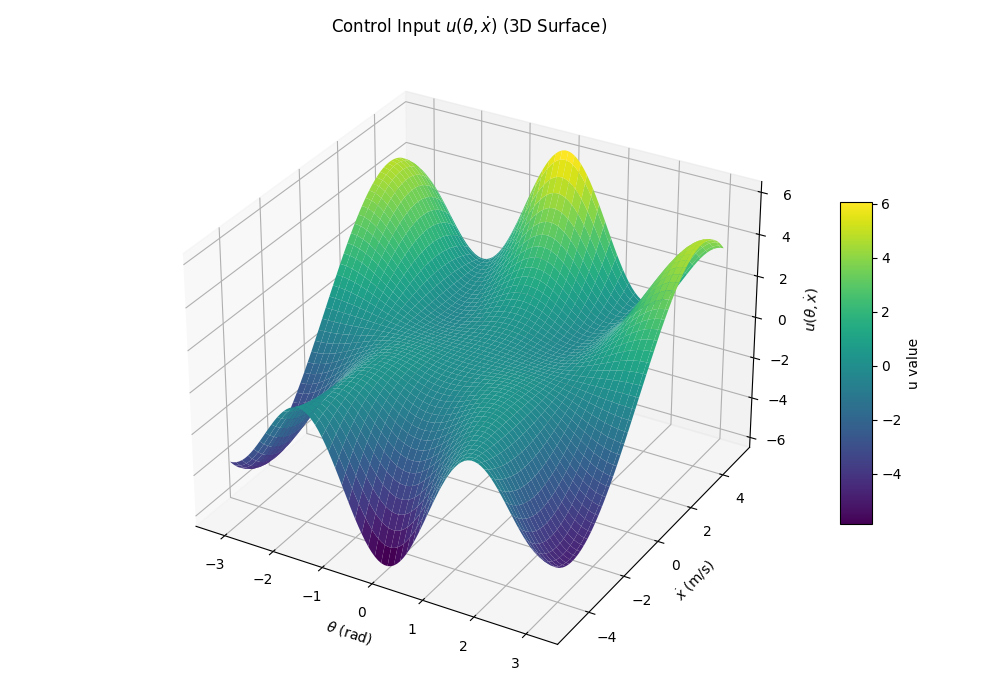

In [ ]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

# dict_state = {x: 1, theta: 0, x_dot: 0, theta_dot: 0}
dict_const = {m: 0.1, M: 1, l: 1, g: 9.81}
dict_swing = {u_a: 1, lam: 1}

x_sym, theta_sym, x_dot_sym, theta_dot_sym = sp.symbols(
    "x theta xdot thetadot", real=True
)

dict_state = {
    x: x_sym,
    theta: theta_sym,
    x_dot: x_dot_sym,
    theta_dot: theta_dot_sym,
}

u_numeric = (
    csp.make_state_comfy_to_see(u).subs(dict_const).subs(dict_swing).subs(dict_state)
)
u_numeric = u_numeric.simplify()

u_func = sp.lambdify(
    (x, x_dot_sym, theta_sym, theta_dot_sym), u_numeric, modules="numpy"
)

dV_dt_numeric = (
    csp.make_state_comfy_to_see(dV_dt)
    .subs(dict_const)
    .subs(dict_swing)
    .subs(dict_state)
)
dV_dt_numeric = dV_dt_numeric.simplify()
dV_dt_func = sp.lambdify(
    (x, x_dot_sym, theta_sym, theta_dot_sym), dV_dt_numeric, modules="numpy"
)

# --- 5. 상태 변수 범위 설정 ---

theta_vals = np.linspace(-np.pi, np.pi, 100)
x_dot_vals = np.linspace(-5, 5, 100)
theta_dot_vals = np.linspace(-10, 10, 100)
Theta, X_dot = np.meshgrid(theta_vals, x_dot_vals)

# --- 6. 수치 계산 ---
U_vals = u_func(0, 0, Theta, X_dot)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Theta, X_dot, U_vals, cmap='viridis', edgecolor='none')

ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r'$\dot{x}$ (m/s)')
ax.set_zlabel(r'$u(\theta, \dot{x})$')
ax.set_title('Control Input $u(\\theta, \dot{x})$ (3D Surface)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='u value')

plt.tight_layout()
plt.show()